In [1]:
# All credits to Junpeng Lao
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/mcmc/examples/smc_demo.ipynb

In [2]:
%load_ext autoreload
%autoreload 2
dark_mode = False #@param {type:"boolean"}
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az

import tensorflow.compat.v1 as tf1
import tensorflow.compat.v2 as tf

import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transform_fn, make_transformed_log_prob)

tfd = tfp.distributions
tfb = tfp.bijectors

tf.enable_v2_behavior()

sns.set(style="ticks", context="talk")
if dark_mode:
  plt.style.use("dark_background")
  dot_color = 'w'
else:
  plt.style.use("seaborn-darkgrid")
  dot_color = 'k'

%matplotlib inline

### Simplest example - Mixture model

In [3]:
import pymc4 as pm
X = tf.random.normal((200,))+2.2

In [4]:
@pm.model
def model():
    u = yield pm.Uniform("u", -4, 4)
    m = yield pm.Normal("m", u, 1, observed=X)
    return m

In [5]:
samples = pm.sample_smc(model())

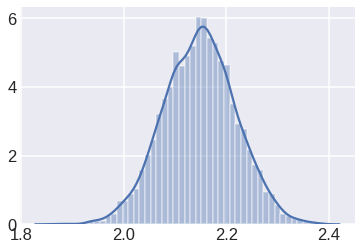

In [6]:
sns.distplot(samples)

### Robust regression with mixture likelihood¶

In [7]:
dfhogg = pd.DataFrame(
                np.array([[1, 201, 592, 61, 9, -0.84],
                          [2, 244, 401, 25, 4, 0.31],
                          [3, 47, 583, 38, 11, 0.64],
                          [4, 287, 402, 15, 7, -0.27],
                          [5, 203, 495, 21, 5, -0.33],
                          [6, 58, 173, 15, 9, 0.67],
                          [7, 210, 479, 27, 4, -0.02],
                          [8, 202, 504, 14, 4, -0.05],
                          [9, 198, 510, 30, 11, -0.84],
                          [10, 158, 416, 16, 7, -0.69],
                          [11, 165, 393, 14, 5, 0.30],
                          [12, 201, 442, 25, 5, -0.46],
                          [13, 157, 317, 52, 5, -0.03],
                          [14, 131, 311, 16, 6, 0.50],
                          [15, 166, 400, 34, 6, 0.73],
                          [16, 160, 337, 31, 5, -0.52],
                          [17, 186, 423, 42, 9, 0.90],
                          [18, 125, 334, 26, 8, 0.40],
                          [19, 218, 533, 16, 6, -0.78],
                          [20, 146, 344, 22, 5, -0.56]]),
                columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

dfhogg['id'] = dfhogg['id'].apply(lambda x: 'p{}'.format(int(x)))
dfhogg.set_index('id', inplace=True)
dfhogg.head()

,x,y,sigma_y,sigma_x,rho_xy
id,,,,,
p1,201.0,592.0,61.0,9.0,-0.84
p2,244.0,401.0,25.0,4.0,0.31
p3,47.0,583.0,38.0,11.0,0.64
p4,287.0,402.0,15.0,7.0,-0.27
p5,203.0,495.0,21.0,5.0,-0.33


In [8]:
dfhoggs = ((dfhogg[['x', 'y']] - dfhogg[['x', 'y']].mean(0)) / 
           (2 * dfhogg[['x', 'y']].std(0)))
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / ( 2 * dfhogg['x'].std())
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / ( 2 * dfhogg['y'].std())

In [9]:
dtype = tf.float32
hyper_mean = tf.cast(0, dtype)
hyper_scale = tf.cast(10, dtype)
X = np.float32(dfhoggs['x'].values)
sigma = np.float32(dfhoggs['sigma_y'].values)
Y = np.float32(dfhoggs['y'].values)
Y = Y[None]

In [11]:
@pm.model()
def model():
    b0 = yield pm.Normal("b0", hyper_mean, hyper_scale)
    b1 = yield pm.Normal("b1", hyper_mean, hyper_scale)
    mu_out = yield pm.Normal("mu_out", hyper_mean, 10.)
    sigma_out = yield pm.HalfNormal("sigma_out", scale=tf.cast(1., dtype))
    weight = yield pm.Uniform("weight", low=tf.cast(0, dtype), high=.5)
    x = yield pm.Mixture("x", 
            tf.stack([
                tf.repeat(1-weight[..., tf.newaxis], 20, axis=-1),
                tf.repeat(weight[..., tf.newaxis], 20, axis=-1)
                ], 
                -1
            ),
            [
                pm.Normal.dist(loc=tf.squeeze(b0[..., tf.newaxis] + b1[..., tf.newaxis]*X),
                    scale=np.float32(np.squeeze(sigma))),
                pm.Normal.dist(loc=mu_out[..., tf.newaxis], 
                    scale=tf.squeeze(sigma+sigma_out[..., tf.newaxis]))
            ],
            observed=Y,
        )

In [12]:
final_state = pm.sample_smc(model())

In [13]:
var_name = ['__log_sigma_out', 'b0', 'b1', 'mu_out', 'weight']
posterior = {k:v for k, v in zip(var_name, final_state)}

In [14]:
posterior["sigma_out"] = tf.exp(posterior["__log_sigma_out"])

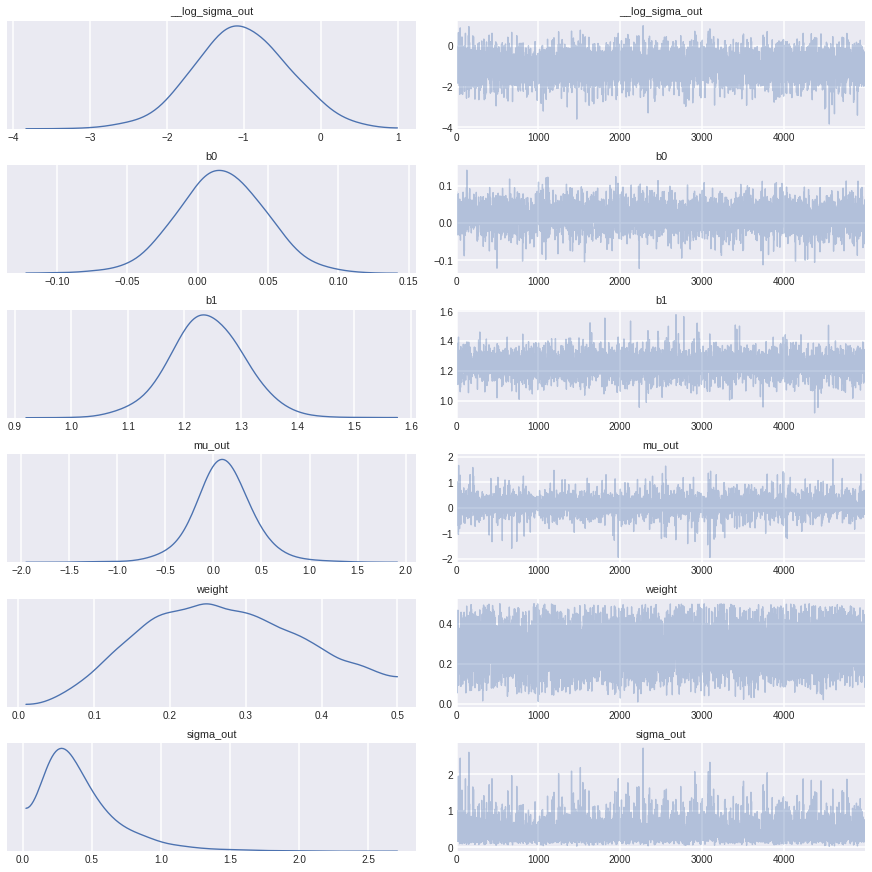

In [15]:
az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace);

In [16]:
%%time
trace = pm.sample(model(), progressbar=True, adaptation_kwargs={"target_accept_prob": 0.8}, initialize_smc=True)

100%|██████████| 1000/1000 [01:50<00:00, 11.92it/s]


CPU times: user 2min 21s, sys: 6.82 s, total: 2min 28s
Wall time: 2min 9s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8350c07a90>,
      dtype=object)

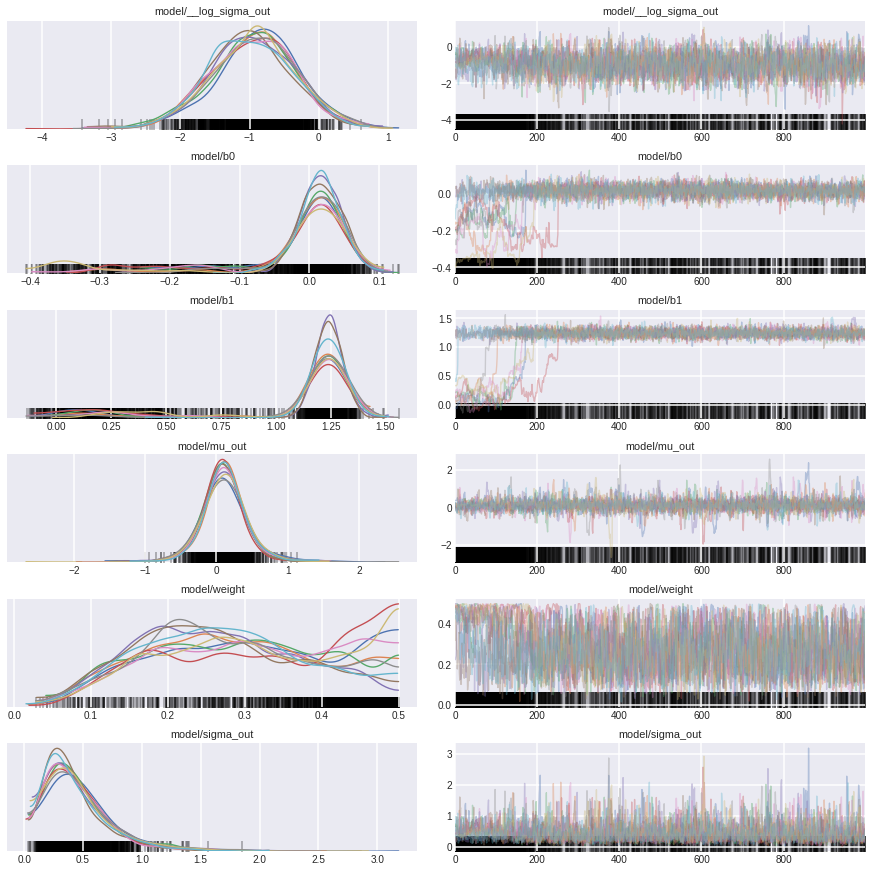

In [18]:
az.plot_trace(trace)

In [ ]:
# I still have huge variance, hope to solve with chains on SMC

In [19]:
%%time
trace = pm.sample(model(), progressbar=True, adaptation_kwargs={"target_accept_prob": 0.8}, initialize_smc=False)

100%|██████████| 1000/1000 [03:23<00:00,  5.98it/s]

CPU times: user 3min 48s, sys: 12.4 s, total: 4min 1s
Wall time: 3min 31s


### Also works with TransformedTransitionKernel and HMC as inner kernel

In [20]:
#TODO: For now I don't see the possibility of determining bijectors of the values since they are implemented
# with pm.Potential and can be determined by passing through the graph.

### Display fitted result and outliner probability

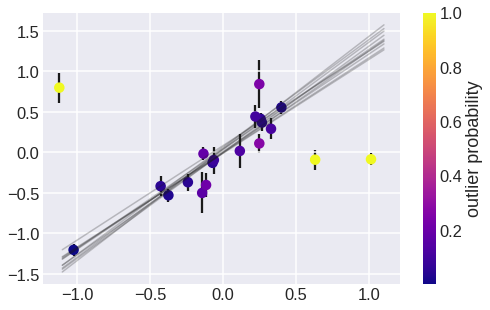

In [21]:
__log_sigma_out, b0, b1, mu_out, weight = [
    tf.reshape(x, (500*10, 1)) for x in final_state]
sigma_out = tf.exp(__log_sigma_out)

X = np.float32(dfhoggs['x'].values[tf.newaxis, ...])
sigma = np.float32(dfhoggs['sigma_y'].values[tf.newaxis, ...])
y_obs = np.float32(dfhoggs['y'].values[tf.newaxis, ...])

_, ax = plt.subplots(1, 1, figsize=(8, 5))
x_fit = np.linspace(-1.1, 1.1, 100)[None, :]
ax.plot(x_fit.T, np.transpose(b0[:10] + b1[:10]*x_fit), 
        alpha=.25, lw=1.5, color=dot_color)


outlier_logp = tf.math.log(weight) + tfd.Normal(
    loc=mu_out, scale=sigma+sigma_out).log_prob(y_obs)

marg_logp = tfd.Mixture(
    tfd.Categorical(probs=tf.stack(
        [tf.repeat(1-weight, 20, axis=1),
         tf.repeat(weight, 20, axis=1)], 2)),
    [
        tfd.Normal(loc=b0 + b1*X, scale=sigma),
        tfd.Normal(loc=mu_out, scale=sigma+sigma_out)
    ]
).log_prob(y_obs)

logp_outlier = outlier_logp - marg_logp

ax.errorbar(dfhoggs['x'],
            dfhoggs['y'], 
            yerr=dfhoggs['sigma_y'], 
            fmt=','+dot_color, 
            zorder=-1)

p_outlier = np.exp(np.median(logp_outlier, axis=0))

plt.scatter(dfhoggs['x'], dfhoggs['y'], c=p_outlier, cmap='plasma')
plt.colorbar(ax=ax, label="outlier probability");